In [2]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import db_connection as db

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# Set up matplotlib
mpl.rcParams['figure.figsize'] = (12, 10)
# tuple where 12 is the width and 10 is the height, measured in inches.
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [8]:
# load the data
file = tf.keras.utils
raw_df = db.read_db("flights_cleaned")
raw_df = raw_df[["gps_altitude_m","speed_km/s","climb_m","climb_m(delta)","climb_rate_m/s","bearing","delta_bearing","glide_ratio","elapsed_time","temp","pressure","humidity","dew_point","wind_speed","wind_deg"]]
raw_df.head()

,gps_altitude_m,speed_km/s,climb_m,climb_m(delta),climb_rate_m/s,bearing,delta_bearing,glide_ratio,elapsed_time,temp,pressure,humidity,dew_point,wind_speed,wind_deg
0,2083,27.164986,-2.0,0.0,-2.0,11,3.0,3.772915,17.0,25.62,1008.0,35.0,9.04,0.66,75.0
1,2082,28.697530,-3.0,0.0,-3.0,21,10.0,2.657179,18.0,25.62,1008.0,35.0,9.04,0.66,75.0
2,2080,43.046289,-2.0,0.0,-2.0,21,0.0,5.978651,19.0,25.62,1008.0,35.0,9.04,0.66,75.0
3,2079,34.146645,-1.0,-14.0,-1.0,38,17.0,9.485179,20.0,25.62,1008.0,35.0,9.04,0.66,75.0
4,2078,34.146634,0.0,-14.0,0.0,38,0.0,0.000000,21.0,25.62,1008.0,35.0,9.04,0.66,75.0


In [9]:
raw_df.describe()

,gps_altitude_m,speed_km/s,climb_m,climb_m(delta),climb_rate_m/s,bearing,delta_bearing,glide_ratio,elapsed_time,temp,pressure,humidity,dew_point,wind_speed,wind_deg
count,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06
mean,2.517768e+03,4.990280e+01,2.011514e-02,5.513045e-01,1.975983e-02,1.450012e+02,9.961753e+00,7.455871e+00,1.358669e+04,3.093591e+01,1.007325e+03,2.692119e+01,9.116711e+00,3.264907e+00,2.300101e+02
std,6.624665e+02,1.591653e+01,2.137012e+00,3.642395e+01,2.085181e+00,9.039138e+01,1.312044e+01,5.867016e+00,8.037768e+03,3.494276e+00,2.377966e+00,7.386355e+00,3.039939e+00,1.376462e+00,1.140969e+02
min,1.600000e+01,2.560542e+00,-1.300000e+01,-1.650000e+02,-6.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.960000e+01,1.001000e+03,9.000000e+00,-2.230000e+00,0.000000e+00,0.000000e+00
25%,2.059000e+03,3.952668e+01,-1.000000e+00,-2.700000e+01,-1.000000e+00,6.900000e+01,2.000000e+00,3.029444e+00,6.706000e+03,2.863000e+01,1.006000e+03,2.200000e+01,7.000000e+00,2.300000e+00,1.900000e+02
50%,2.520000e+03,5.115990e+01,0.000000e+00,1.000000e+00,0.000000e+00,1.470000e+02,6.000000e+00,6.436344e+00,1.340300e+04,3.061000e+01,1.007000e+03,2.700000e+01,9.310000e+00,3.270000e+00,2.630000e+02
75%,2.967000e+03,6.156538e+01,1.000000e+00,2.700000e+01,1.000000e+00,2.000000e+02,1.300000e+01,1.141784e+01,2.008000e+04,3.314000e+01,1.009000e+03,3.200000e+01,1.124000e+01,4.180000e+00,3.290000e+02
max,8.500000e+03,9.949969e+01,1.300000e+01,1.650000e+02,6.500000e+00,3.570000e+02,1.800000e+02,2.869482e+01,3.646100e+04,4.111000e+01,1.015000e+03,5.800000e+01,2.225000e+01,8.700000e+00,3.600000e+02


In [5]:
neg, pos = np.bincount(raw_df["zone"])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 173943
    Positive: 91173 (52.42% of total)



In [6]:
cleaned_df = raw_df.copy()

# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop("zone"))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop("zone"))
test_labels = np.array(test_df.pop("zone"))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')

Average class probability in training set:   0.5240
Average class probability in validation set: 0.5219
Average class probability in test set:       0.5266


In [7]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (111323,)
Validation labels shape: (27831,)
Test labels shape: (34789,)
Training features shape: (111323, 15)
Validation features shape: (27831, 15)
Test features shape: (34789, 15)


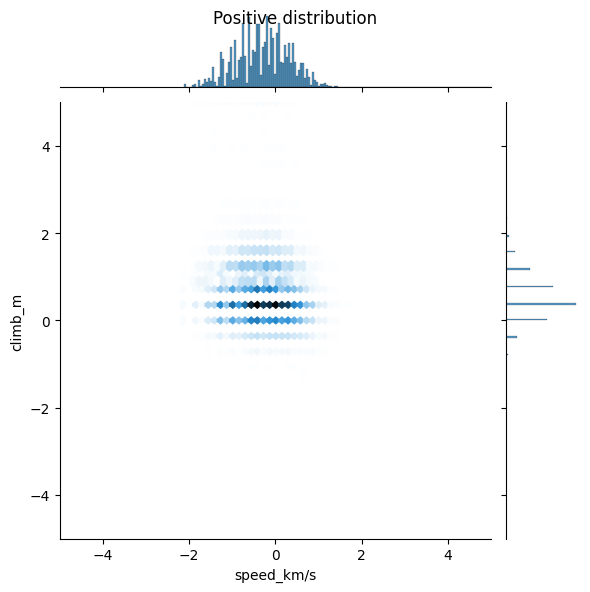

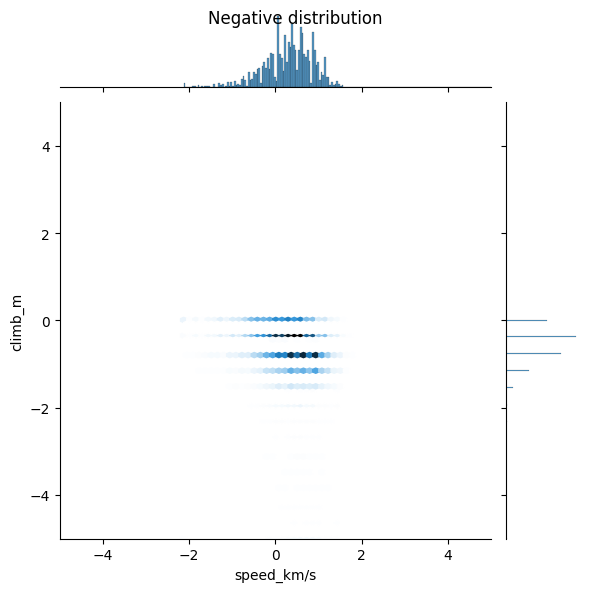

In [8]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df["speed_km/s"], y=pos_df["climb_m"],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df["speed_km/s"], y=neg_df["climb_m"],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [9]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model


EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


model = make_model()
model.summary()

e:\Wolf\Belgeler\Projelerim\Paragliding_Flight_Analyses\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273 (1.07 KB)

 Trainable params: 273 (1.07 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[0.40060005],
       [0.76191586],
       [0.43459302],
       [0.55563295],
       [0.76677644],
       [0.6023493 ],
       [0.58539426],
       [0.5547942 ],
       [0.52975976],
       [0.61495984]], dtype=float32)

In [11]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.7961


In [12]:
initial_bias = np.log([pos/neg])
initial_bias

array([0.09669312])

In [13]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


array([[0.6341604 ],
       [0.615417  ],
       [0.5048651 ],
       [0.5225221 ],
       [0.44328898],
       [0.64628947],
       [0.50994766],
       [0.5048728 ],
       [0.67621505],
       [0.48089388]], dtype=float32)

In [14]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.7336


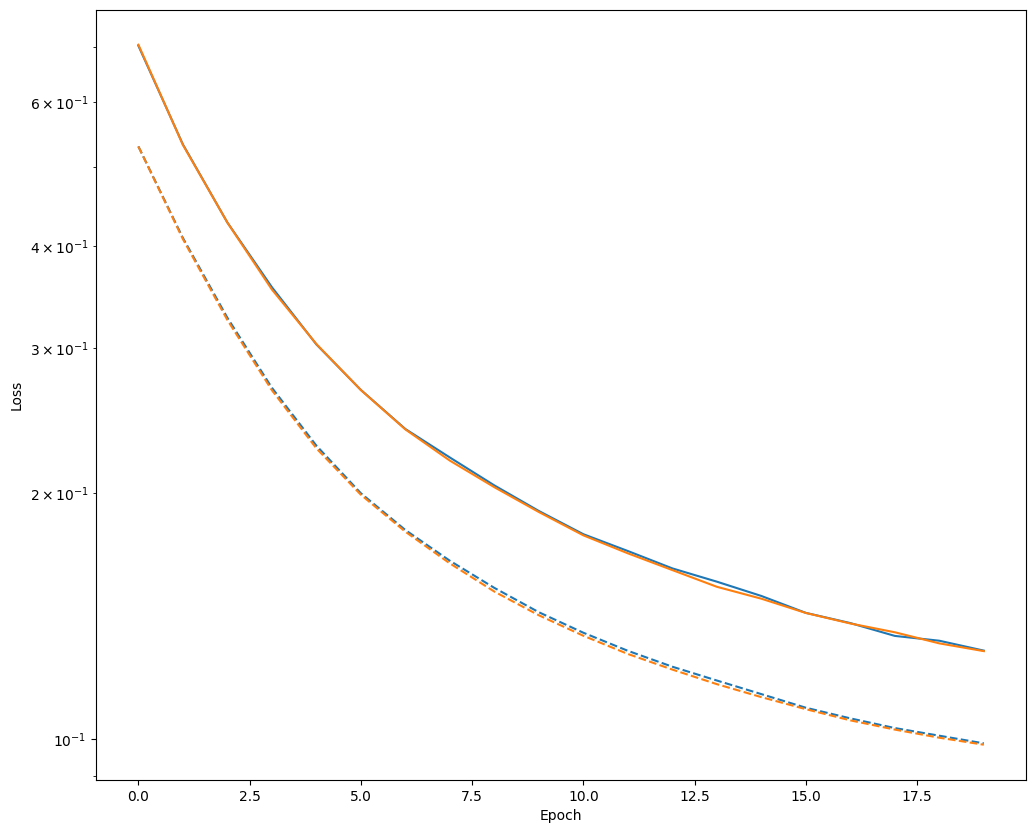

In [15]:
initial_weights = os.path.join(tempfile.mkdtemp(), "initial_weights.weights.h5")
model.save_weights(initial_weights)

model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)


model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [16]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7155 - auc: 0.8093 - fn: 12614.6963 - fp: 13861.8213 - loss: 0.7513 - prc: 0.8357 - precision: 0.7233 - recall: 0.7408 - tn: 27176.7500 - tp: 32462.1250 - val_accuracy: 0.7929 - val_auc: 0.8711 - val_fn: 3170.0000 - val_fp: 2594.0000 - val_loss: 0.5288 - val_prc: 0.8914 - val_precision: 0.8140 - val_recall: 0.7818 - val_tn: 10712.0000 - val_tp: 11355.0000
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7078 - auc: 0.7785 - fn: 8675.9824 - fp: 7783.5894 - loss: 0.5645 - prc: 0.7992 - precision: 0.7255 - recall: 0.7078 - tn: 20026.9648 - tp: 21797.8574 - val_accuracy: 0.8667 - val_auc: 0.9428 - val_fn: 2318.0000 - val_fp: 1392.0000 - val_loss: 0.4083 - val_prc: 0.9485 - val_precision: 0.8976 - val_recall: 0.8404 - val_tn: 11914.0000 - val_tp: 12207.0000
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8061 - auc: 0.8871 - fn: 6138.0356 - fp: 4894.7681 - loss: 0.4466 - prc: 0.8984 - precision: 0.8284 - 

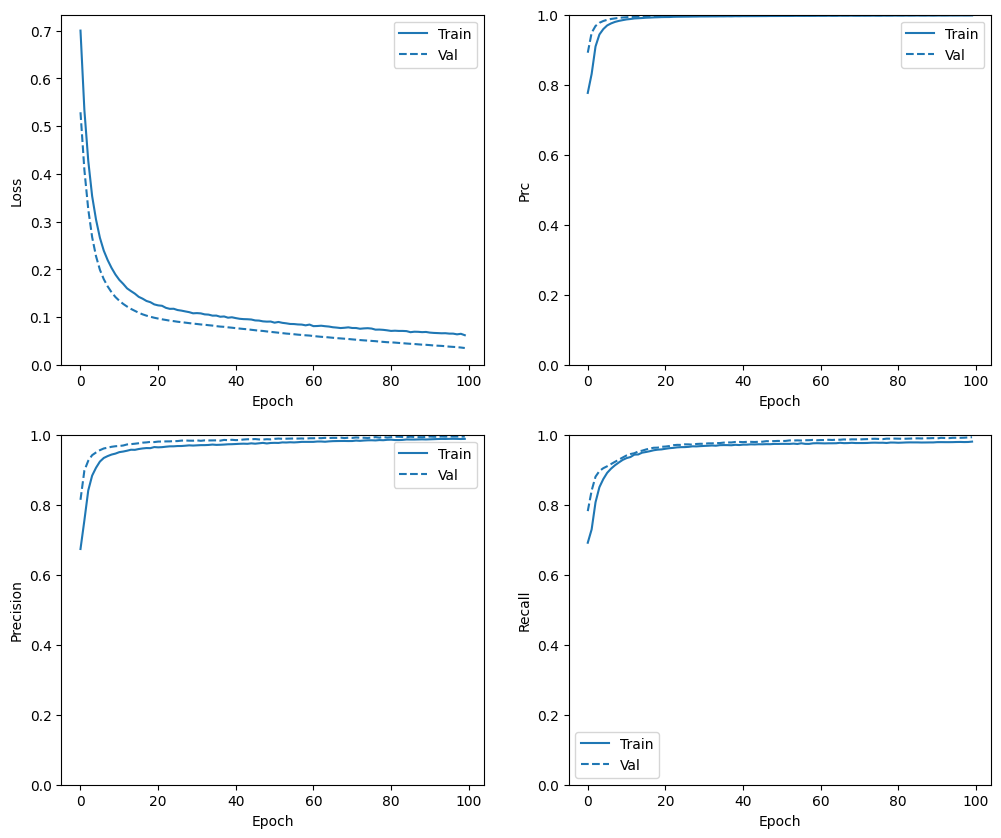

In [17]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

plot_metrics(baseline_history)

In [18]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


loss :  0.03560379147529602
compile_metrics :  18201.0

Legitimate Transactions Detected (True Negatives):  16355
Legitimate Transactions Incorrectly Detected (False Positives):  115
Fraudulent Transactions Missed (False Negatives):  118
Fraudulent Transactions Detected (True Positives):  18201
Total Fraudulent Transactions:  18319


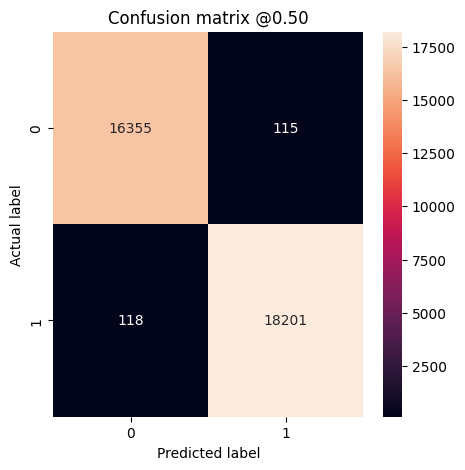

In [19]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

Legitimate Transactions Detected (True Negatives):  15072
Legitimate Transactions Incorrectly Detected (False Positives):  1398
Fraudulent Transactions Missed (False Negatives):  22
Fraudulent Transactions Detected (True Positives):  18297
Total Fraudulent Transactions:  18319
Legitimate Transactions Detected (True Negatives):  12116
Legitimate Transactions Incorrectly Detected (False Positives):  4354
Fraudulent Transactions Missed (False Negatives):  14
Fraudulent Transactions Detected (True Positives):  18305
Total Fraudulent Transactions:  18319


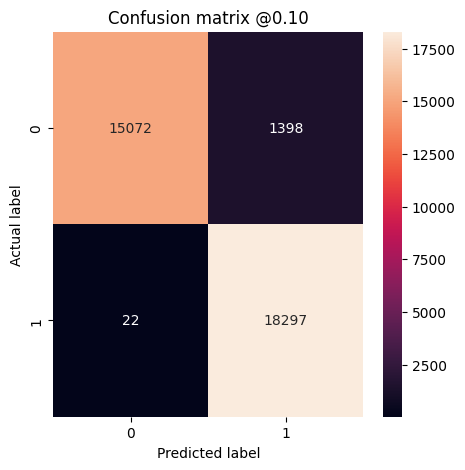

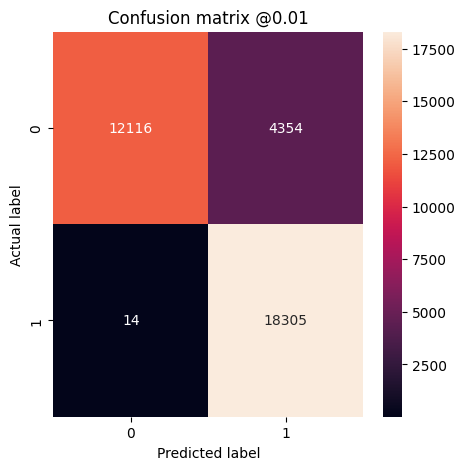

In [20]:
plot_cm(test_labels, test_predictions_baseline, 0.1)
plot_cm(test_labels, test_predictions_baseline, 0.01)

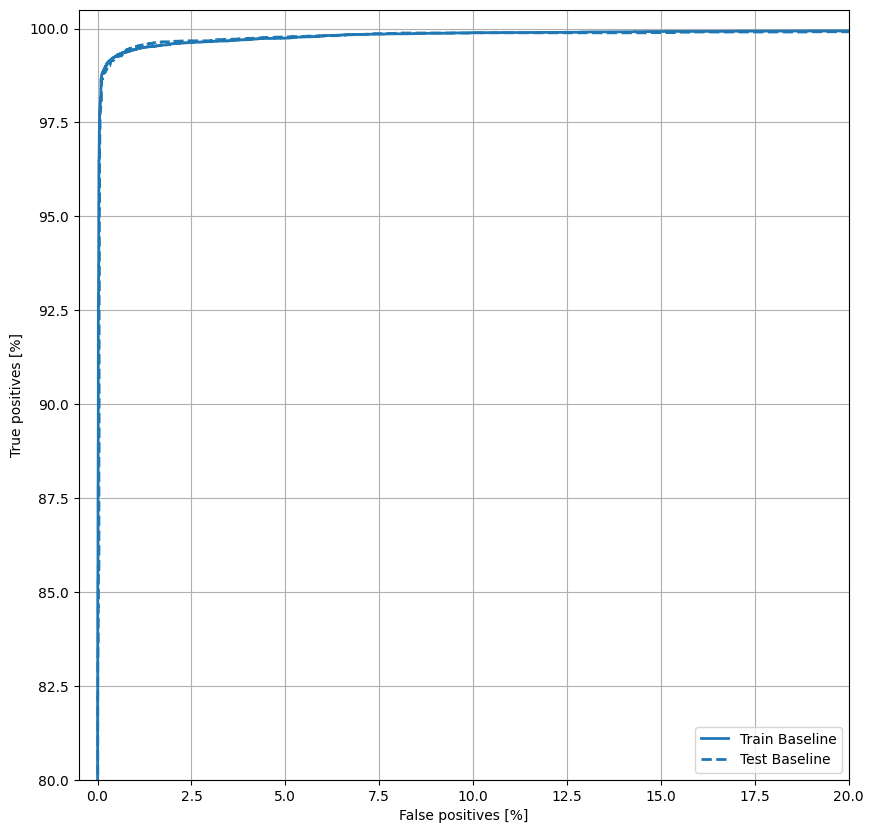

In [21]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

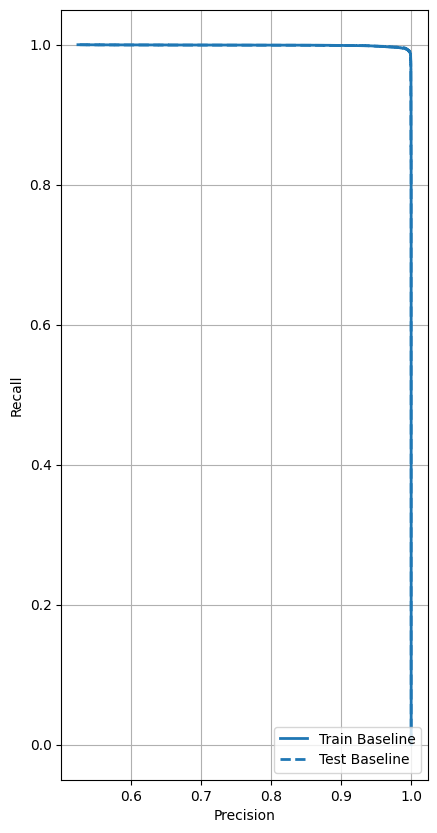

In [22]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [23]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.05
Weight for class 1: 0.95


In [24]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100


e:\Wolf\Belgeler\Projelerim\Paragliding_Flight_Analyses\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7413 - auc: 0.8427 - fn: 12777.8574 - fp: 13449.7324 - loss: 0.7615 - prc: 0.8676 - precision: 0.7501 - recall: 0.7616 - tn: 30690.4102 - tp: 36155.3945 - val_accuracy: 0.7953 - val_auc: 0.8706 - val_fn: 3704.0000 - val_fp: 1993.0000 - val_loss: 0.5281 - val_prc: 0.8913 - val_precision: 0.8445 - val_recall: 0.7450 - val_tn: 11313.0000 - val_tp: 10821.0000
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7040 - auc: 0.7783 - fn: 9532.5176 - fp: 7078.6787 - loss: 0.5639 - prc: 0.8018 - precision: 0.7355 - recall: 0.6804 - tn: 20664.8574 - tp: 21008.3398 - val_accuracy: 0.8641 - val_auc: 0.9435 - val_fn: 2711.0000 - val_fp: 1072.0000 - val_loss: 0.4074 - val_prc: 0.9491 - val_precision: 0.9168 - val_recall: 0.8134 - val_tn: 12234.0000 - val_tp: 11814.0000
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8010 - auc: 0.8852 - fn: 6924.6250 - fp: 4385.0713 - loss: 0.4481 - prc: 0.8970 - precision: 0.8384 - 

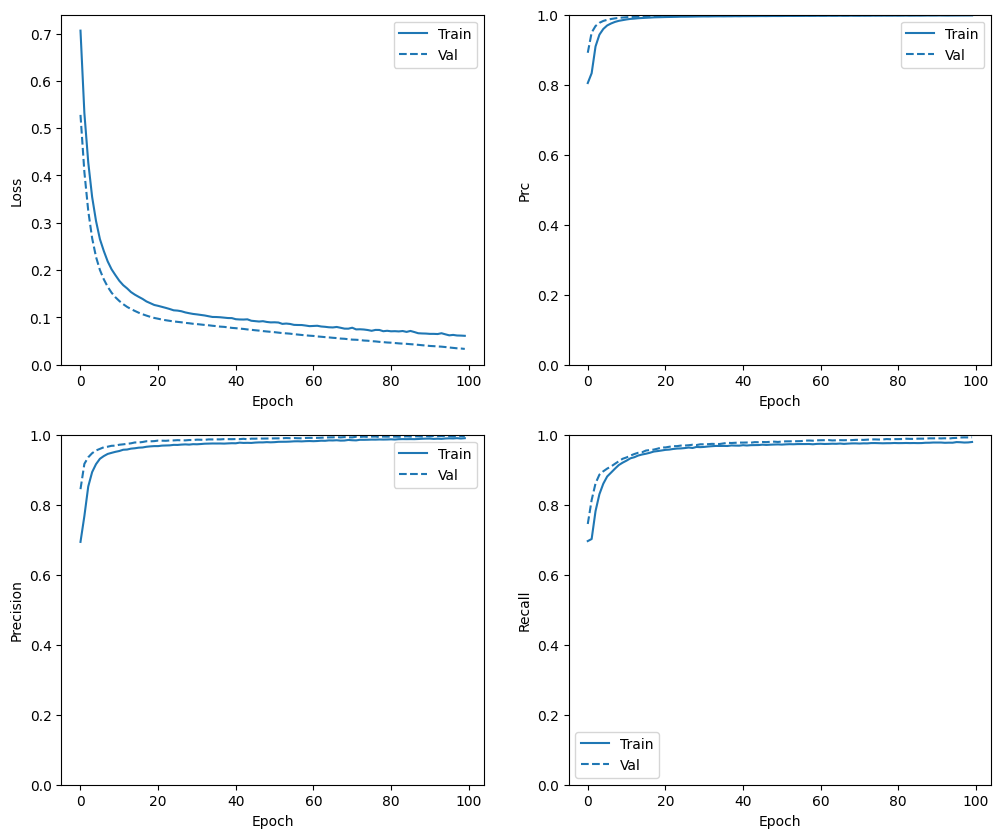

In [25]:
plot_metrics(weighted_history)

In [26]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


loss :  0.034038808196783066
compile_metrics :  18195.0

Legitimate Transactions Detected (True Negatives):  16390
Legitimate Transactions Incorrectly Detected (False Positives):  80
Fraudulent Transactions Missed (False Negatives):  124
Fraudulent Transactions Detected (True Positives):  18195
Total Fraudulent Transactions:  18319


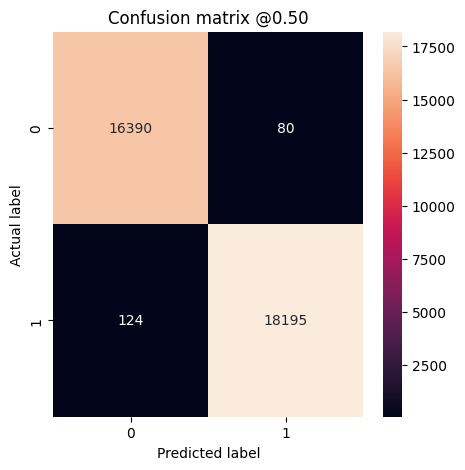

In [27]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

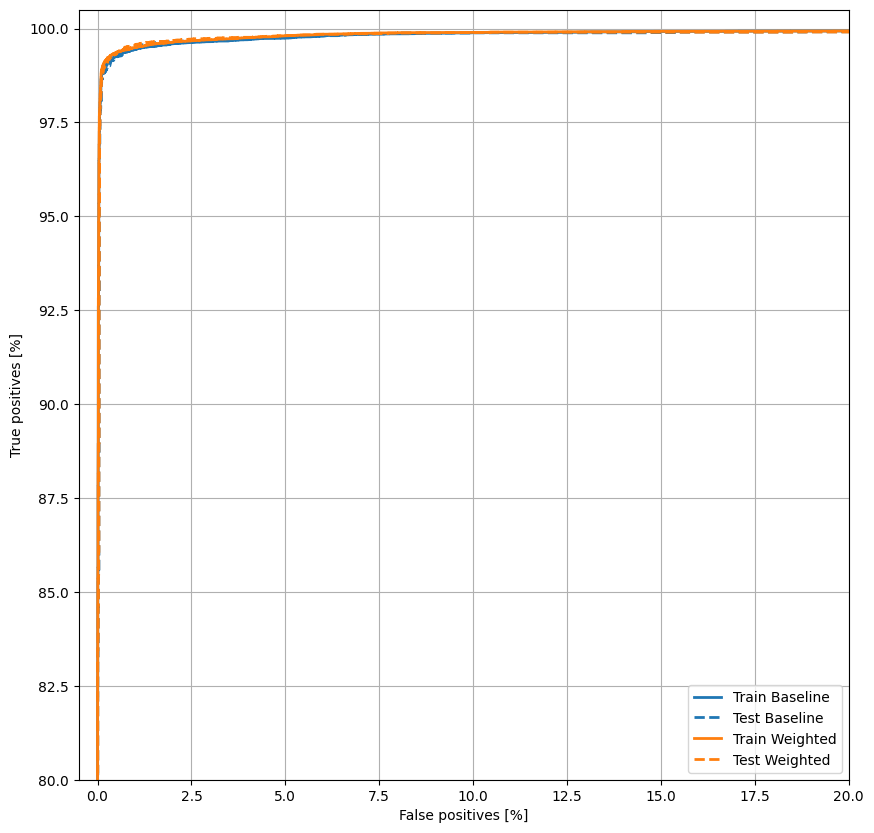

In [28]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

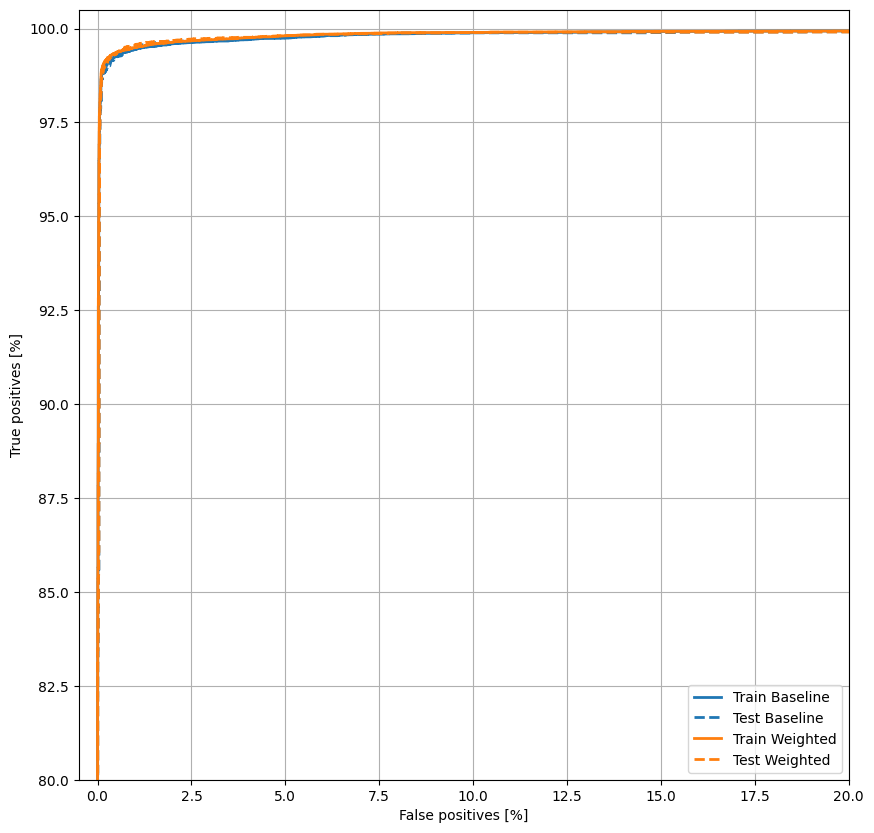

In [29]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

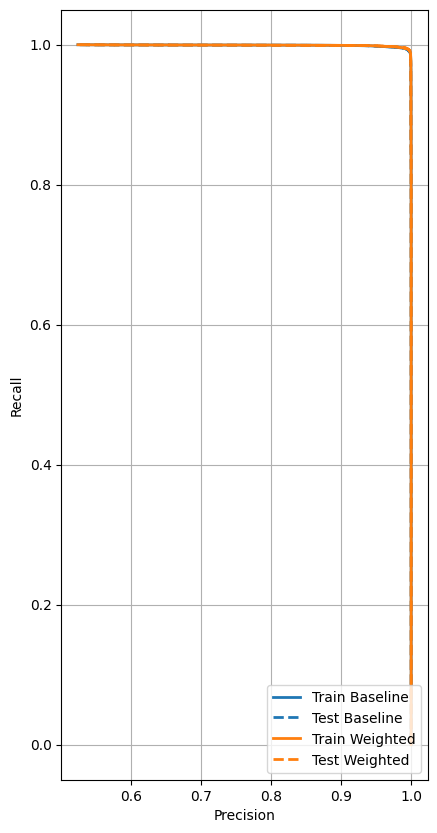

In [30]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

In [31]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(52994, 15)

In [32]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(105988, 15)

In [33]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-0.22679575  0.22093916  0.39924684 -0.05688893  0.54936988  0.06159989
 -0.1398076   0.85890729 -1.08669742 -1.05110369  1.51594679  0.7945555
  0.19527958  1.15671914  0.92325409]

Label:  1
